# Plot layer with maximum energy, overlaid at rechits, CLUE2D and CLUE3D levels

In [2]:
import sys
from dataclasses import dataclass
from enum import Enum, auto

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

sys.path.append("../../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

In [3]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v38'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)

In [4]:
class Level(Enum):
    RECHITS = auto()
    CLUSTER_2D = auto()
    CLUSTER_3D = auto()

@dataclass
class PlotInfo:
    beamEnergy:int
    datatype:str

In [5]:
def getHist(info:PlotInfo, level:Level, profile=False):
    if profile:
        projections = {}
    else:
        projections = {
            "beamEnergy": hist.loc(info.beamEnergy),
        }
    if level is Level.RECHITS:
        if profile:
            h_name = "RechitsMeanLayerWithMaximumEnergy"
        else:
            h_name = "RechitsLayerWithMaximumEnergy"
        projectOn = "rechits_layer"
    elif level is Level.CLUSTER_2D:
        if profile:
            h_name = "MeanLayerWithMaximumClustered2DEnergy"
        else:
            h_name = "LayerWithMaximumClustered2DEnergy"
        projectOn = "clus2D_layer"
    elif level is Level.CLUSTER_3D:
        if profile:
            h_name = "Clus3DMeanLayerWithMaximumClusteredEnergy"
        else:
            h_name = "Clus3DLayerWithMaximumClusteredEnergy"
        projectOn = "layer_with_max_clustered_energy"
        projections["mainOrAllTracksters"] = hist.loc("mainTrackster")
    else:
        assert(False)
    if profile:
        projectOn = "beamEnergy_custom"
        kind = HistogramKind.PROFILE
    else:
        kind = HistogramKind.COUNT
    h = (histStore
        .get(HistogramId(h_name, clueParams, info.datatype))
        .getHistogram(kind))
    if len(projections) > 0:
        h = h[projections]
    return h.project(projectOn)

In [6]:
getHist(PlotInfo(datatype="data", beamEnergy=20), level=Level.CLUSTER_3D,profile=True)

Hist(IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy_custom', label='Beam energy (GeV)'), storage=Mean()) # Sum: Mean(count=168015, value=8.31322, variance=3.29679)

In [7]:
def makePlotLayerDistribution(h_rechits, h_2D, h_3D, plotInfo:PlotInfo):
    plt.figure()
    plt.xlabel("Layer")
    plt.ylabel("Event count")
    
    hep.histplot([h_rechits, h_2D, h_3D], yerr=False, label=["Rechits", "Layer cluster", "CLUE3D trackster\n(main trackster only)"])

    plt.xlim(1, 16)
    if plotInfo.datatype == "data":
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext("$e^+$ " + str(plotInfo.beamEnergy) + " GeV")
    plt.legend()

def makePlotProfile(h_rechits, h_2D, h_3D, plotInfo:PlotInfo, ax=None, lumi=True,
        plot_kwargs:dict[str, str]=dict(fmt='o-'), individual_plot_kwargs:list[dict]=None, appendDataSim=False):
    if ax is None:
        fig, ax = plt.subplots()
    plot_kwargs = plot_kwargs.copy()
    fmt = plot_kwargs.pop("fmt")
    labels = ["Rechits", "Layer cluster", "CLUE3D trackster\n(main trackster only)"]
    if appendDataSim:
        for i in range(len(labels)):
            if plotInfo.datatype == "data":
                labels[i] += " (Data)"
            else:
                labels[i] += " (Simulation)"
    if individual_plot_kwargs is None:
        individual_plot_kwargs = [dict() for _ in labels]
    for h, label, individual_plot_kwargs_cur in zip([h_rechits, h_2D, h_3D], labels,
                individual_plot_kwargs):
        ax.plot([h.axes[0].bin(i) for i in range(h.axes[0].size)], h.view(flow=False).value, fmt, label=label,
            **(plot_kwargs | individual_plot_kwargs_cur))

    ax.set_xlabel("Beam energy (GeV)")
    ax.set_ylabel("Mean layer with maximum energy")
    ax.set_xticks([h.axes[0].bin(i) for i in range(h.axes[0].size)])
    ax.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    ax.legend()
    if not lumi:
        return
    if plotInfo.datatype == "data":
        hep.cms.text("Preliminary", ax=ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=ax)
    hep.cms.lumitext("$e^+$ test beam", ax=ax)
    

## Distribution of layer with max energy

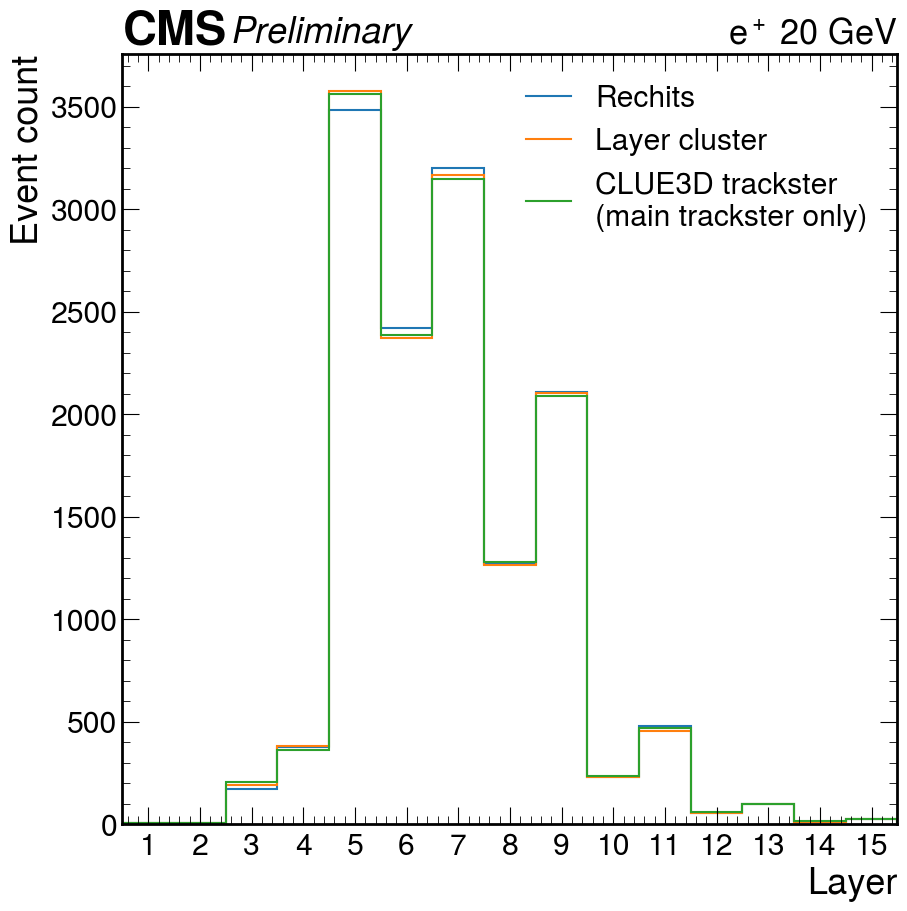

In [8]:
plotInfo = PlotInfo(datatype="data", beamEnergy=20)
makePlotLayerDistribution(*(getHist(plotInfo, level) for level in Level), plotInfo=plotInfo)

## Profile of layer with max energy, fct of beam energy

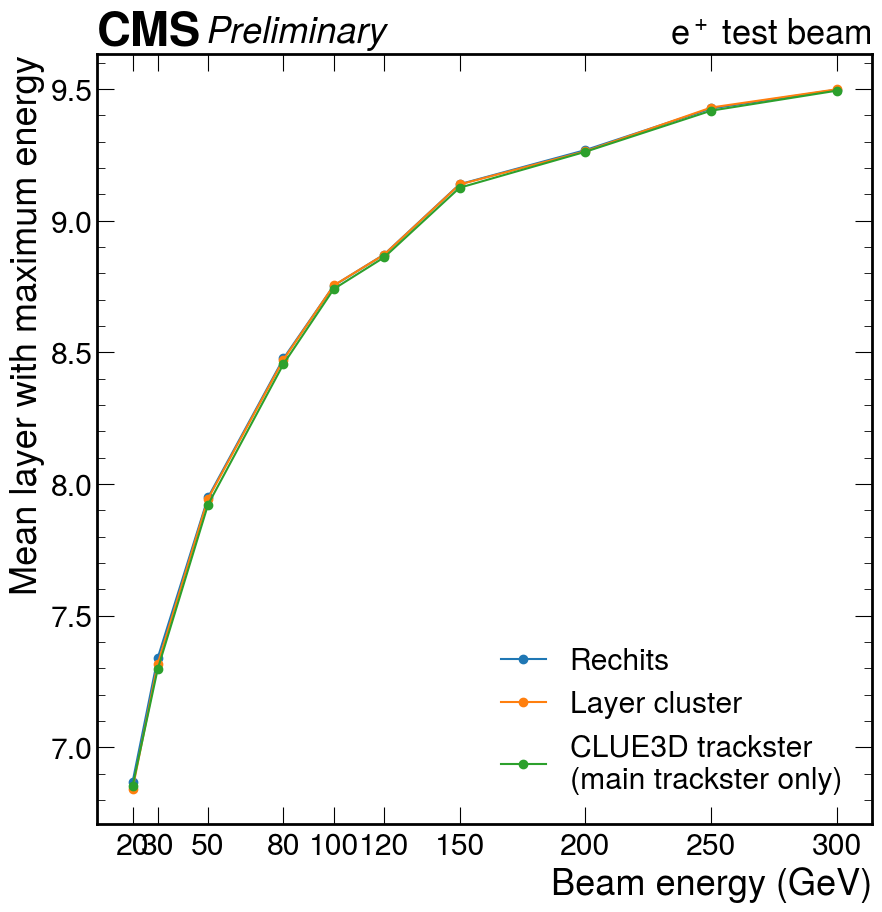

In [9]:
plotInfo = PlotInfo(datatype="data", beamEnergy=None)
makePlotProfile(*(getHist(plotInfo, level, profile=True) for level in Level), plotInfo=plotInfo)

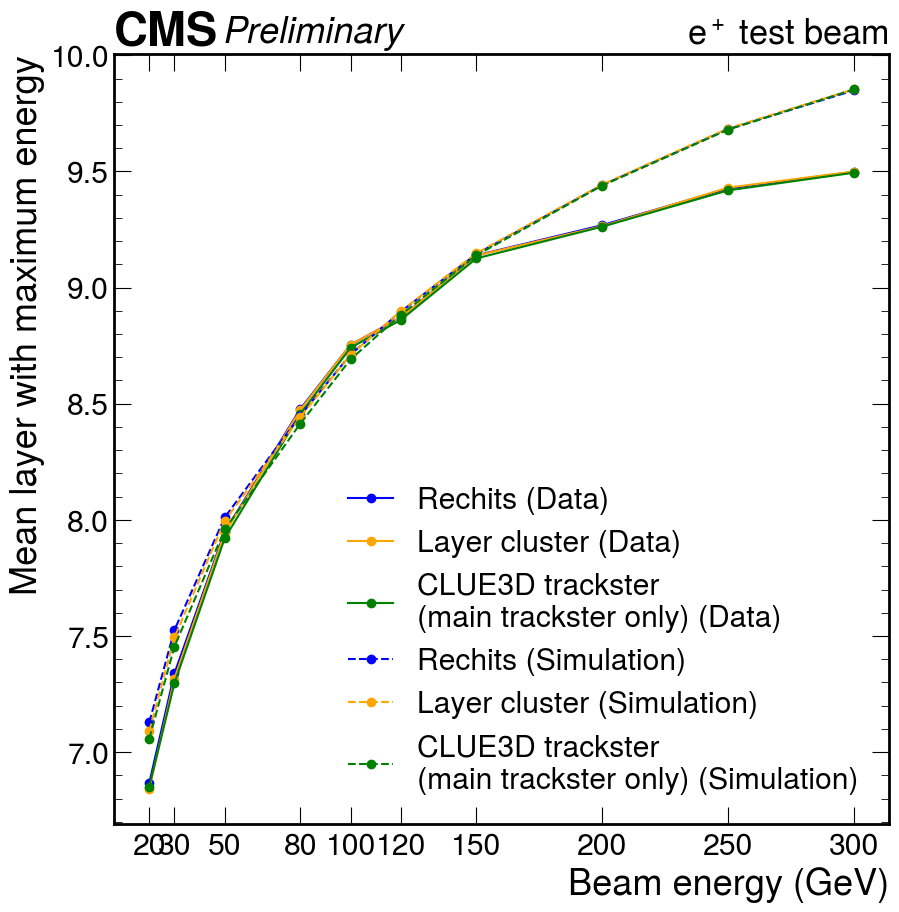

In [10]:
fig, ax = plt.subplots()
common_kwargs = dict(individual_plot_kwargs=[dict(color="blue"), dict(color="orange"), dict(color="green")],
    ax=ax, appendDataSim=True)
plotInfo = PlotInfo(datatype="data", beamEnergy=None)
makePlotProfile(*(getHist(plotInfo, level, profile=True) for level in Level), plotInfo=plotInfo, **common_kwargs)
plotInfo = PlotInfo(datatype="sim_proton_v46_patchMIP", beamEnergy=None)
makePlotProfile(*(getHist(plotInfo, level, profile=True) for level in Level), plotInfo=plotInfo, lumi=False, plot_kwargs=dict(fmt="o--"),
    **common_kwargs)

### Rechits, compare data and simulations

In [14]:
def makePlotProfileSameLevel(hists:dict[str, hist.Hist], ax=None, lumi=True,
        plot_kwargs:dict[str, str]=dict(fmt='o-'), individual_plot_kwargs:list[dict]=None):
    if ax is None:
        fig, ax = plt.subplots()
    plot_kwargs = plot_kwargs.copy()
    fmt = plot_kwargs.pop("fmt")

    if individual_plot_kwargs is None:
        individual_plot_kwargs = [dict() for _ in hists]
    
    for (datatype, h), individual_plot_kwargs_cur in zip(hists.items(), individual_plot_kwargs):
        ax.plot([h.axes[0].bin(i) for i in range(h.axes[0].size)], h.view(flow=False).value, fmt, label=datatype,
            **(plot_kwargs | individual_plot_kwargs_cur))

    ax.set_xlabel("Beam energy (GeV)")
    ax.set_ylabel("Mean layer with maximum energy")
    ax.set_xticks([h.axes[0].bin(i) for i in range(h.axes[0].size)])
    ax.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    ax.legend()
    if not lumi:
        return
    if plotInfo.datatype == "data":
        hep.cms.text("Preliminary", ax=ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=ax)
    hep.cms.lumitext("$e^+$ test beam", ax=ax)
    

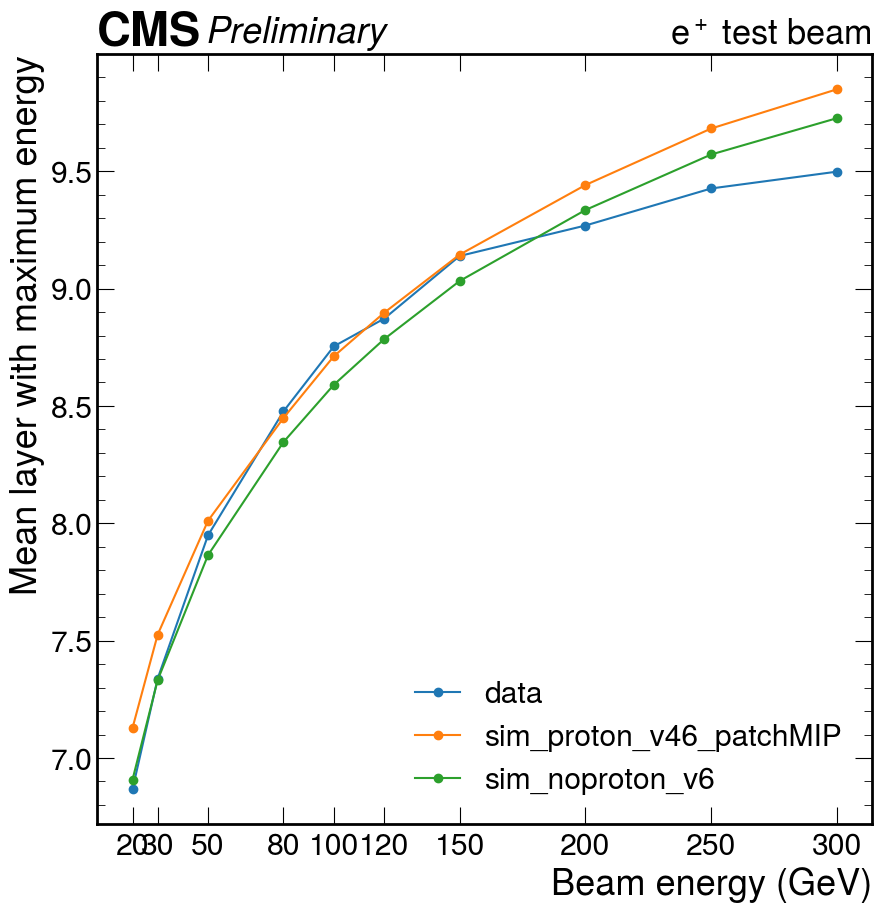

In [15]:
hists = {}
for datatype in ["data", "sim_proton_v46_patchMIP", "sim_noproton_v6"]:
    hists[datatype] = getHist(PlotInfo(None, datatype), Level.RECHITS, profile=True)
makePlotProfileSameLevel(hists)

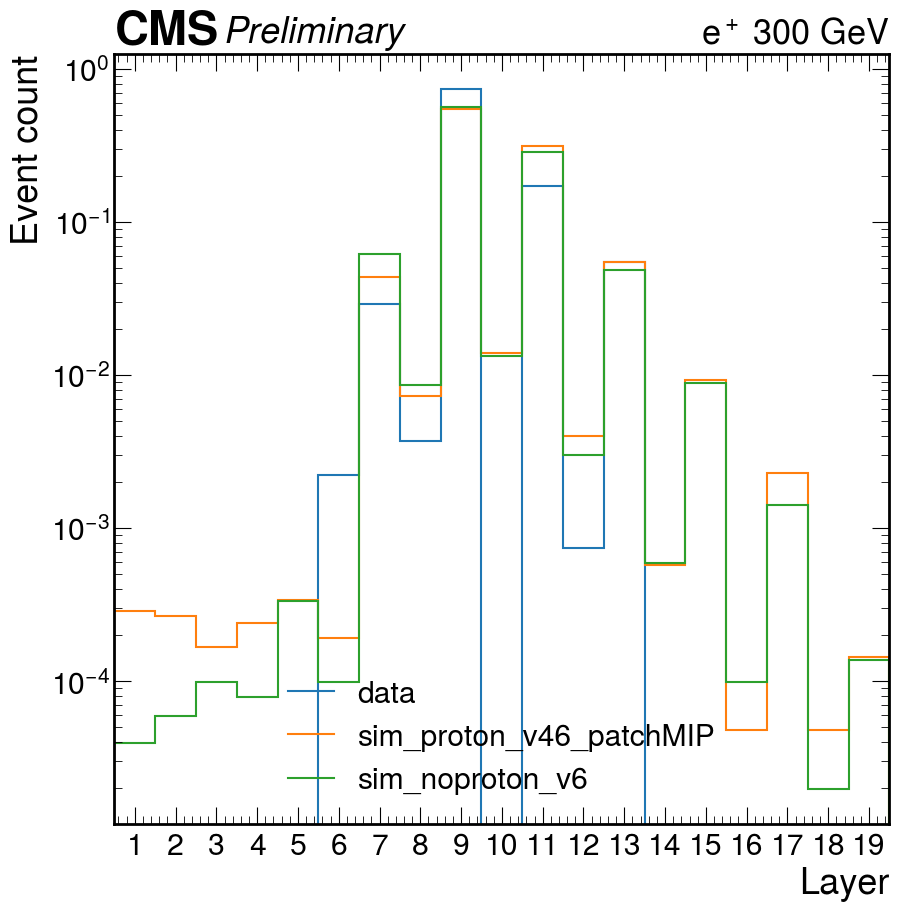

In [25]:
def makePlotLayerDistributionSameLevel(hists:dict[str, hist.Hist], beamEnergy):
    plt.figure()
    plt.xlabel("Layer")
    plt.ylabel("Event count")
    
    hep.histplot(list(hists.values()), yerr=False, label=hists.keys(), density=True)

    plt.xlim(1, 20)
    plt.yscale("log")
    hep.cms.text("Preliminary")
    hep.cms.lumitext("$e^+$ " + str(beamEnergy) + " GeV")
    plt.legend()

beamEnergy = 300
makePlotLayerDistributionSameLevel({datatype : getHist(PlotInfo(beamEnergy, datatype), Level.RECHITS, profile=False) for datatype in ["data", "sim_proton_v46_patchMIP", "sim_noproton_v6"]}, beamEnergy)